# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

Importamos los datos de reviews pero como es un dataset muy grande solo tomamos la tercera parte por ello el parametro de n=3. Inicialmente iniciamos el proceso cn un n=10 pero el resultado fu eun dataset con muchso usuarios que habian jugado una sola vez un juego con lo cual para el ejercicio del sistema de recomendacion no era un dataset valido.

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 3
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

Como el dataset es muy grande me genero un backup por si lo arruino durante el proceso

In [4]:
data_reviews_bkp=data_reviews.copy()
data_reviews_bkp.head(1)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,user_id,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN


In [5]:
# Solo para emergencias!!
data_reviews=data_reviews_bkp.copy()

## PARTE A: Análisis exploratorio de datos

**Games**

Importamos el dataset de juegos. Como no es un dataset grande lo tomamos directamente en el 100% 

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

**Análisis de los atributos de cada dataset**

In [7]:
data_reviews.head(2)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,user_id,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN


In [8]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


**Análisis de valores Faltantes**

In [9]:
data_reviews.isna().sum()

username              0
hours              8771
products           4930
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     2196982
user_id         1539195
compensation    2548852
dtype: int64

Si bien existen varios atributos con muchos  valores faltantes. Es importante que no existan valores faltantes en el atributo <strong> product_id </strong> dado que es el atributo que hace el "join" con el dataset data_games que cuenta con los datos de los juegos. Si deberemos trabajar con el atributo <strong>user_id</strong> pues es mandatorio que por cada "producto_id" tengamos un "user_id" para poder evaluar el modelo. El resto de las columnas con valores faltantes no son necesarias y las eliminaremos del dataframe. 

**¿Cómo tratar los faltantes en user_id?** 

Podriamos agrupar el dataset por nombre de usuario y ver si al menos una vez cada usuario tiene su ID. De ser asi podriamos utilizar esa tabla y reemplazar en el dataset original


In [10]:
user_analisis=data_reviews[['username','user_id']]
user_analisis

,username,user_id
0,Chaos Syren,NaN
1,Cyderine916,NaN
2,nd,NaN
3,Otomji,NaN
4,Phr0stY_D3mon,NaN
...,...,...
2597685,Zezztah,NaN
2597686,Evorix,76561197962161824
2597687,worldoftanks,76561198010660367
2597688,Wildman_,NaN


In [11]:
user_analisis.groupby(by='username').count()

,user_id
username,
!,3
! !,0
! *,0
! AbuAbdalla,1
! Tiggernymph !,0
...,...
󰀓Heavy Unit󰀓,0
󰀕 Africa's Population 󰀕,0
󰀖Boof Investor,0


Para validad la idea creamos un nuevo dataset llamado <strong>user_analisis</strong> que solo contenga dos atributos "username" y "user_id" luego lo agrupamos por el atributo "username" y contamos la cantidad de ID por nombre de usuarios. Para poder aplicar la estrategia antes descripta deberíamos tener en todas las filas del resultado al menos un valor en la columna user_id, lo que indicaría que al menos una vez el usaurio tiene el ID registrado en el dataset. Si esto no es así  no podremos utilizar esta estrategia. Y por lo que se ve claramente hay usuarios que nunca tienen registrado su user_id con lo cual deberemos ir por el plan B: <strong> Generar un ID único para cada usuario </strong>

**Eliminamos las columnas que no usaremos**

Antes de seguir dejaremos el dataset más liviano eliminando las columnas que no nos sirven

In [12]:
data_reviews.drop(['date', 'products','page_order','text','early_access','compensation','found_funny','page', 'user_id'], axis=1, inplace=True)

In [13]:
data_reviews.head(2)

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Cyderine916,5.0,35140


Construimos un dataset nuevo con la lista de usuarios única más el nuevo ID generado

In [14]:
import numpy as np
usuarios=data_reviews['username'].unique()
usr_unico=pd.DataFrame(usuarios,columns=['username'])   
finRango=len(usr_unico)+1
user_id=np.array(range(1,finRango,1))
usr_unico['user_id']=user_id
usr_unico


,username,user_id
0,Chaos Syren,1
1,Cyderine916,2
2,nd,3
3,Otomji,4
4,Phr0stY_D3mon,5
...,...,...
1315959,Crit_Magnet_,1315960
1315960,vinao bala tronxa,1315961
1315961,Evorix,1315962
1315962,worldoftanks,1315963


Agregamos la columna a "data_reviews"

In [15]:
data_reviews=data_reviews.merge(usr_unico, left_on='username', right_on='username')

In [16]:
data_reviews

,username,hours,product_id,user_id
0,Chaos Syren,0.1,725280,1
1,Cyderine916,5.0,35140,2
2,Cyderine916,180.5,377160,2
3,nd,1.0,725280,3
4,nd,2.9,654350,3
...,...,...,...,...
2597685,Crit_Magnet_,16.0,252490,1315960
2597686,vinao bala tronxa,345.2,252490,1315961
2597687,Evorix,2775.2,252490,1315962
2597688,worldoftanks,82.2,252490,1315963


***NaN Resueltos, y que pasa con la columna ¿Ranking?***

Hasta aquí hemos resuelto los valores faltantes en "user_id" ahora el problema que debemos resolver es la columna de ranking. Pues el dataset no cuenta con una columna de ranking. Si cuenta con una columna de horas jugadas, con lo cual luego de pensar varias horas y ensayar cosas decidimos crear un ranking en base a las horas jugadas

***1.Hagamos un primer analisis de la columna"hours" a ver como se distribuye*** 

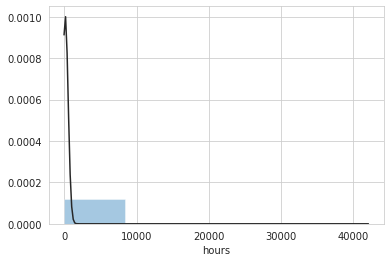

In [17]:
import seaborn as sns
from scipy.stats import norm
sns.set_style("whitegrid")
x = data_reviews.hours
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

En un primer análisis rápido pareciera como que las horas mayores a 100 podrían ser outliers que podrían ser tratados con por ejemplo el método de rangos intercuartilicos, pero también pueden ser valores extremos útiles y no necesariamente outliers. Parsa saberlo vamos a cuantificarlos

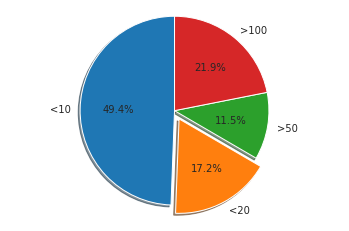

In [18]:
menorQue10=len(data_reviews[data_reviews.hours<10])
menorQue20=len(data_reviews[(data_reviews.hours>10)&(data_reviews.hours<20)])
mayorQue50=len(data_reviews[(data_reviews.hours>50)&(data_reviews.hours<100)])
mayoresQue100=len(data_reviews[data_reviews.hours>100])


import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['<10', '<20', '>50', '>100']
sizes = [menorQue10, menorQue20, mayorQue50, mayoresQue100]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Claramente no podemos tratar esos valores extremos como outliers. Pues representan casi el 22% de los datos. Perderíamos mucho sacándolos. Lo que haremos entonces es definir un escalado de datos de modo de transformar esas horas en un valor de rating. de 1 a 10.

***2. Generamos la columna rating***

In [19]:
# Agregao una columna denominada "rating" toda en valor cero.

data_reviews['rating']=0
data_reviews.head(1)

,username,hours,product_id,user_id,rating
0,Chaos Syren,0.1,725280,1,0


In [20]:
rank=[10,20,30,40,50,60,70,80,90]

for valor in rank:
    data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)

data_reviews['rating'][(data_reviews.hours>=100) ]=10



<ipython-input-20-6df6932cb948>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)
<ipython-input-20-6df6932cb948>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews['rating'][(data_reviews.hours>(valor-10)) & (data_reviews.hours<=valor)]=(valor/10)


In [21]:
# Elimino la columna hours pues ya no la necesito mas
data_reviews.drop(columns=['hours'], inplace=True)

**Ahora sí!. Los NaN y la columna rating están resueltas**

Vamos a ver de que forma nos quedó la distribución del ranking. Evidentemente la mayoria de los juegos están entre 1 y 4 , y también hay un gran porcentaje en 10 de rating, es decir que jugaron más de 100 horas.

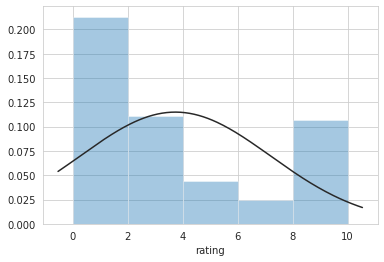

In [22]:
import seaborn as sns
from scipy.stats import norm
sns.set_style("whitegrid")
x = data_reviews.rating
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

Volvemos a hacer un gráfico de torta para ver bien como se reparten los valores del ranking

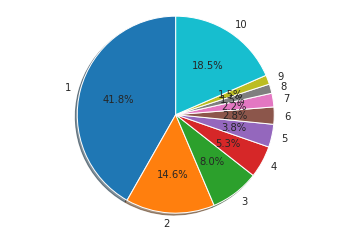

In [23]:
r1=len(data_reviews[data_reviews.rating==1])
r2=len(data_reviews[data_reviews.rating==2])
r3=len(data_reviews[data_reviews.rating==3])
r4=len(data_reviews[data_reviews.rating==4])
r5=len(data_reviews[data_reviews.rating==5])
r6=len(data_reviews[data_reviews.rating==6])
r7=len(data_reviews[data_reviews.rating==7])
r8=len(data_reviews[data_reviews.rating==9])
r9=len(data_reviews[data_reviews.rating==9])
r10=len(data_reviews[data_reviews.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [24]:
data_reviews.isna().sum()

username      0
product_id    0
user_id       0
rating        0
dtype: int64

## Análisis de "data_games"

In [25]:
data_games.head(1)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN


Analizamos los valores faltantes

In [26]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

***Análisis de los atributos***

De los atributos del dataset sólo dejaremos las columnas que para nuestro análisis son significativas estas son:
    
+ app_name
+ id ( que prepresenta el product_id)

El resto de las columnas a los fines de la predicción no son necesarias, al menos para este trabajo. Incluso la columna "title" la cual es igual a la columna"app_name" y además cuenta con muchos valores faltantes. Con lo cual nos quedaremos solo con la columna "app_name"

In [27]:
# Elimino la columna que no usaremos
data_games.drop(columns=['title','publisher','genres','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], inplace=True)

In [28]:
data_games.head()

,app_name,id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570


In [29]:
data_games.describe()

,app_name,id
count,32133,32133
unique,32094,32132
top,Soundtrack,612880
freq,3,2


Analizamos valores faltantes

In [30]:
data_games.isna().sum()

app_name    2
id          2
dtype: int64

Dado que sólo hay dos filas con valores faltantes eliminamos esas dos filas. 

In [31]:
data_games.dropna(inplace=True)

In [32]:
data_games.isna().sum()

app_name    0
id          0
dtype: int64

El último paso es renombrar la columna "id" a "product_id" para que se llame del mismo modo que en el dataset "data_reviews".

In [33]:
data_games.rename(columns={'id': 'product_id'}, inplace=True)
data_games

,app_name,product_id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570
...,...,...
32130,Colony On Mars,773640
32131,LOGistICAL: South Africa,733530
32132,Russian Roads,610660
32133,EXIT 2 - Directions,658870


***Trabajo Terminado*** El datasset <strong> data_games </strong> está listo para cumplir su función en este modelo.

 
## Parte B: Análisis con Surprice
 

Ahora que tenemos todos los datasets listos procederemos a entrenar y predecir con la bilioteca "Surprice". El primer paso es importar las librerías.

In [34]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


El primer paso  es crear una instancia de la clase "reader" de surprice, indicandole en sus hiperparámetros en la escala de la columna "rating". Dado que nuestro rango va de 1 a 10 si dejáramos el rango por default qu eva de 1 a 5 la ejecución del modelo no seria del todo buena.

In [35]:
reader = Reader(rating_scale=(1, 10)) # Esta libreria se usa para parsear un archivo de rating que debe tener la forma de user ; item ; rating ; [timestamp] https://surprise.readthedocs.io/en/stable/reader.html

Creamos el dataset de surpriseen base a "data_reviews".

En base a lo que hemos visto del dataset "data_review" hay muchos usuarios que parecieran haber rankeado una sola vez o dos y del punto de vista del modelo no seria tan bueno entrenar con estas instancias. Pero apra etar seguros vamos a analizar el dataset contando por cada usurio la cantidad de instancias. 

In [36]:
filtro=data_reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
filtro

,product_id,rating
user_id,,
1,1,1
2,2,2
3,92,92
4,1,1
5,64,64
...,...,...
1315960,1,1
1315961,1,1
1315962,1,1


Nos quedaremos con todos aquellos usuarios que hayan rankeado mas de 5 veces.


59027


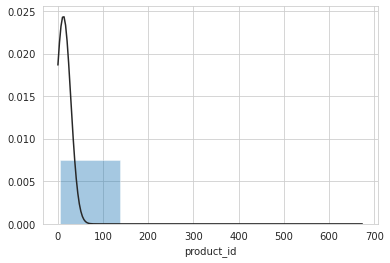

In [38]:

filtro=filtro[(filtro.product_id>5) ]
print(len(filtro))
sns.set_style("whitegrid")
x = filtro.product_id
ax = sns.distplot(x, fit=norm, kde=False, bins=5)
 

In [39]:
filtro_usuarios=pd.DataFrame(filtro)
filtro_usuarios

,product_id,rating
user_id,,
3,92,92
5,64,64
7,46,46
9,7,7
10,412,412
...,...,...
1074987,7,7
1090444,7,7
1092669,6,6


In [40]:
filtro= filtro.rename_axis('user_id').reset_index()

In [41]:
filtro

,user_id,product_id,rating
0,3,92,92
1,5,64,64
2,7,46,46
3,9,7,7
4,10,412,412
...,...,...,...
59022,1074987,7,7
59023,1090444,7,7
59024,1092669,6,6
59025,1094782,6,6


Vamos a graficar con un gráfico de torta la distribución del rating. Si bien se podría hacer con un histograma este tipo de gráficas es más claro en cuanto a la distrbución. Para hacerlo usamos una variable por cada rating pues si le diéramos todo el dataset para procesar tardaría mucho tiempo.


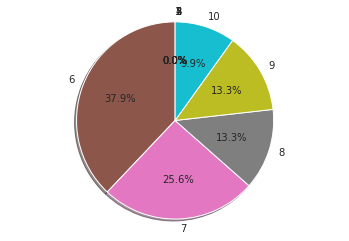

In [42]:
r1=len(filtro[filtro.rating==1])
r2=len(filtro[filtro.rating==2])
r3=len(filtro[filtro.rating==3])
r4=len(filtro[filtro.rating==4])
r5=len(filtro[filtro.rating==5])
r6=len(filtro[filtro.rating==6])
r7=len(filtro[filtro.rating==7])
r8=len(filtro[filtro.rating==9])
r9=len(filtro[filtro.rating==9])
r10=len(filtro[filtro.rating==10])
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [1,2,3,4,5,6,7,8,9,10]
sizes = [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
explode = (0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Definimos un dataset nuevo denominado "grupo de usuarios filtrados" donde sólo constan los usaurios que jugaron más de dos juegos al menos.

In [43]:
grupo_usuarios=filtro['user_id'].values
data_reviews_filtrado=data_reviews[data_reviews.user_id.isin(grupo_usuarios) ]
data_reviews_filtrado


,username,product_id,user_id,rating
3,nd,725280,3,1
4,nd,654350,3,1
5,nd,595480,3,1
6,nd,422650,3,1
7,nd,384150,3,1
...,...,...,...,...
2360930,Sirius O'rely,212680,1102936,7
2360931,Sirius O'rely,244160,1102936,2
2360932,Sirius O'rely,457140,1102936,4
2360933,Sirius O'rely,252490,1102936,4


In [44]:
data = Dataset.load_from_df(data_reviews_filtrado[['user_id', 'product_id', 'rating']], reader)

In [45]:
data

Creamos una instancia de surprise.

In [46]:
from surprise import SVD
algo = SVD()

***Selección de hiperparámetro con cross validation y grid search***

Aplicamos cross validación para evaluar cuál es el número de factores óptimos

In [47]:
rmse_test_means = []
factores = [1,10,20,30,40,50]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))  

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.4782  2.4756  2.4841  2.4793  0.0036  
Fit time          8.10    8.38    8.29    8.26    0.12    
Test time         3.09    3.01    2.82    2.97    0.11    
10
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5311  2.5360  2.5297  2.5323  0.0027  
Fit time          9.71    9.87    9.95    9.85    0.10    
Test time         2.75    2.71    3.14    2.87    0.20    
20
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.5231  2.5064  2.5149  2.5148  0.0068  
Fit time          11.12   11.44   11.40   11.32   0.14    
Test time         2.75    3.05    3.09    2.96    0.15    
30
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.4984  

Corremos grid search, para optimizar hiperparámetros. Volvemos a poner el hiperparámetro "n_factors" sólo para validar que la selección del modelo de "corss validation" fue bueno.

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,10,15,20,50],'n_epochs': [5, 10,20,30], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data)

In [48]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.5066713512355503
{'n_factors': 1, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}


***Optimización de hiperparámetros terminada!*** vamos a correr el modelo con los hiperparámetros propuestos.

***Separamos en el set de train y de test***

In [51]:
trainset, testset = train_test_split(data, test_size=.33)

Creamos una instancia del modelo con los hiperparámetros propuestos.

In [52]:
from surprise import SVD
algo = SVD(n_factors =1,n_epochs=20,lr_all=0.005,reg_all=0.4 ) 

Hacemos el FIT del modelo

In [53]:
algo.fit(trainset)

In [75]:
predictions = algo.test(testset)

Exploramos un usuario a ver qué películas le gustan y cuáles le recomienda. Para ello seleccionamos un usuario cualquiera al azar

In [67]:
usuario = 418459
rating = 1 
# Filtramos data_reviews
df_user = data_reviews_filtrado[(data_reviews_filtrado['user_id'] == usuario) & (data_reviews_filtrado['rating'] >= rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=data_games, left_on='product_id', right_on='product_id')
# Listamos el resultado
df_user

,username,product_id,user_id,rating,app_name
0,Zaon,313160,418459,3,Farming Simulator 15
1,Zaon,221910,418459,3,The Stanley Parable
2,Zaon,8930,418459,10,Sid Meier's Civilization® V
3,Zaon,285310,418459,4,RollerCoaster Tycoon®: Deluxe
4,Zaon,403640,418459,4,Dishonored 2
5,Zaon,391540,418459,10,Undertale


Creamos un dataframe  donde vamos a guardar las recomendaciones

In [68]:
recomendaciones_usuario =data_games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32132, 1)


,app_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


Sacamos del dataframe todas las películas que ya sabemos que vio

In [69]:
usuario_vistas = data_reviews_filtrado[data_reviews_filtrado['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(6, 4)


,username,product_id,user_id,rating
650192,Zaon,313160,418459,3
650193,Zaon,221910,418459,3
650194,Zaon,8930,418459,10
650195,Zaon,285310,418459,4
650196,Zaon,403640,418459,4


Eliminamos las películas vistas del dataframe de recomendaciones, para que no vuelva a recomendarme  una pelicula que ya vio.

In [70]:
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()


,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Generamos las recomendaciones mediante una función "lambda" que va recorriendo el dataset de recomendaciones y calculando la predicción

In [71]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

Listamos las diez mejores recomendaciones

In [72]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,app_name,Estimate_Score
22837,394360,Hearts of Iron IV,8.113760
7845,482730,Football Manager 2017,7.528012
853,203770,Crusader Kings II,7.501086
387,48700,Mount & Blade: Warband,7.435128
31847,440,Team Fortress 2,7.401539
26948,271590,Grand Theft Auto V,7.393811
23225,281990,Stellaris,7.385420
30266,230410,Warframe,7.330410
29477,39210,FINAL FANTASY XIV Online,7.311859
1043,730,Counter-Strike: Global Offensive,7.280748


Calculamos el RMSE  de la recomendación

In [76]:
from surprise import accuracy 
accuracy.rmse(predictions, verbose=True)

RMSE: 2.5163


2.51631003512456

## Parte C: Investigación

Luego de terminar esta primera parte de los modelos de recomendación. Me gustaría continuar aplicando alguna técnica de Lenguaje Natural para poder trabajar con modelos más complejos de recomendaciones basadas en contenidos. El dataset "games_review" cuenta con mucha información interesante respecto por ejemplo al género del juego que podríamos explotar de pronto haciendo un encoding para no solo predecir en base al ranking sino a los gustos de usuarios simialres.  También podríamos trabajar sobre los comentarios de los juegos tratando de inferir de ellos el gusto o no de los jugadores por el mismo.

Entiendo que para ello deberíamos aplicar técnicas de interpretación de lenguaje natural para trabajar sobre los comentarios del juego o sobre el género del juego. Sin duda que es el próximo paso que quiero dar sobre los sistemas de recomendación. Incluso me interesaría poder esbozar un "bot" el cual mediante algunas consultas pueda proponer un juego. 
